## 1. Camera Calibration with OpenCV

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from os.path import basename
%matplotlib inline

In [2]:
objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] 
imgpoints = []

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'camera_cal/found/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)        
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Calibrate, calculate distortion coefficients, and test undistortion on an image!

Text(0.5,1,'Undistorted Image')

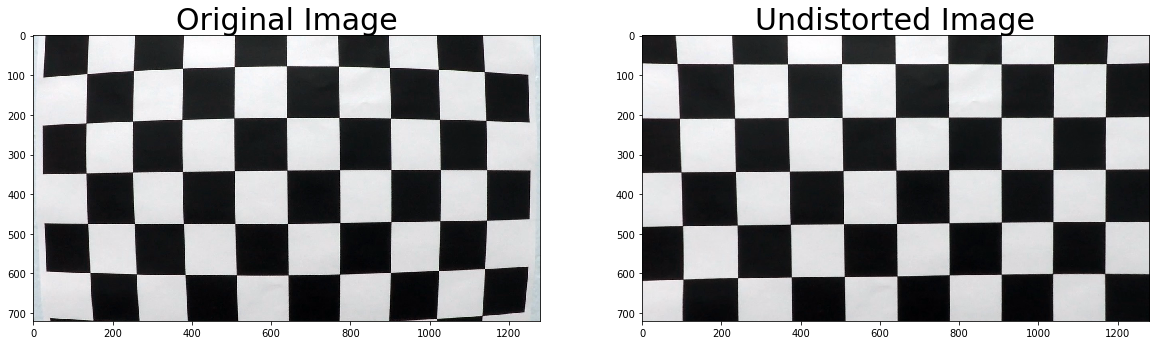

In [3]:
img = cv2.imread('camera_cal/test_image/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_image/test_undist.jpg',dst)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_cal_dist_pickle.p", "wb" ) )


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Undistort road images as a test

In [4]:
# Make a list of images
images = glob.glob('test_images/*.jpg')
images.sort()

In [5]:
images

['test_images/straight_lines1.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

### Plotting function for Orginal test images

In [6]:
def plotImages(images, ncols=1, cmap=None, prefix_label = 'label:'):

    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten() 
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
#         img = cv2.resize(img, None, fx=1 / 2, fy=1 / 2, interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        
        #imag = str(idx) + "undist_img.png"
#         cv2.imwrite('output/str(idx).jpg', img) 

        
        
        axarr[idx].axis('off')
        axarr[idx].imshow(img, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)


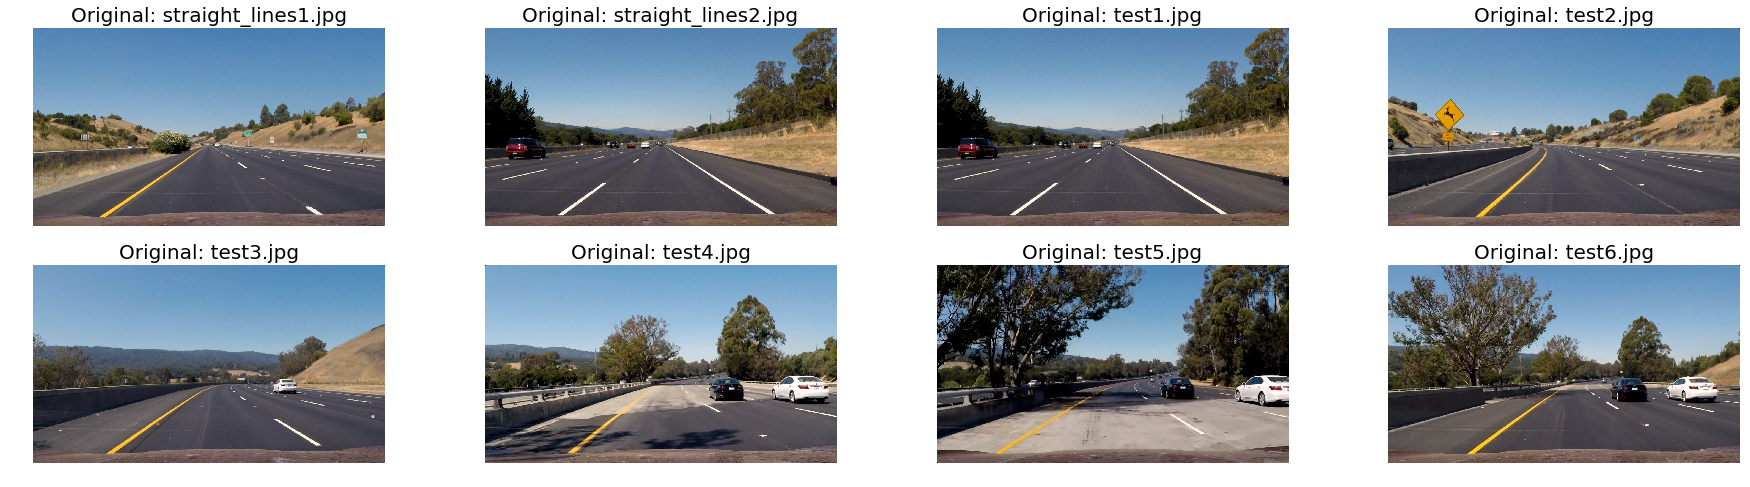

In [7]:
plotImages(images, ncols=4, cmap=None, prefix_label = 'Original:')

### Plotting function for Undistortion images coressponding Orginal test images

In [8]:
def plotImages_undistorted(images, mtx, dist, ncols=1, cmap=None, prefix_label = 'label:'):

    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten() 
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.undistort(img, mtx, dist, None, mtx) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         img = cv2.resize(img, None, fx=1 / 2, fy=1 / 2, interpolation=cv2.INTER_AREA)
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#         filename = "output/undistr_%d.jpg"%idx
#         cv2.imwrite(filename, img)
        
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axarr[idx].axis('off')
        axarr[idx].imshow(img, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)

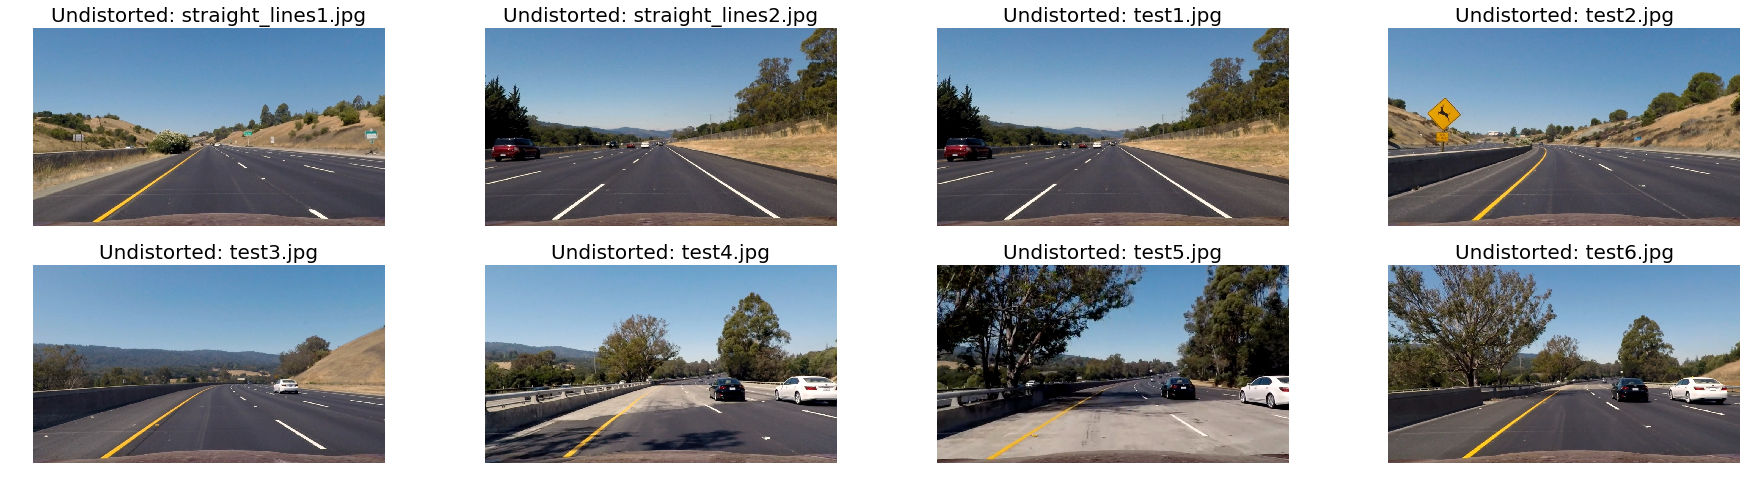

In [9]:
plotImages_undistorted(images, mtx, dist, ncols=4, cmap=None, prefix_label = 'Undistorted:')

## 2. Perspective Transformation

### Here is a function to make sure that transformation source points are always sorted correctly

In [10]:
def order_points(pts):
    # normalises the input into the [0, 2pi] space, added 0.5*pi to initiate from top left
    # which naturally will sort it "counter-clockwise"
    mx = np.sum(pts.T[0]/len(pts))
    my = np.sum(pts.T[1]/len(pts))
   # print(mx)
    #print(my)
    
    #print(pts.T[1][0] )
    

    l = []
    for i in range(len(pts)):
        l.append(  (np.math.atan2(pts.T[0][i] - mx, pts.T[1][i] - my) + 2 * np.pi + 0.5 * np.pi) % (2*np.pi)  )
    sort_idx = np.argsort(l)
    
    return pts[sort_idx[::-1]]

### Here is a function to compute perspective transformation matrices

In [11]:
def get_transform_matrices(pts, img_size):

    src = order_points(pts)

    dst = np.float32([[src[3][0], 0],
                      [src[2][0], 0],
                      [src[2][0], img_size[1]],
                      [src[3][0], img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv

### Test on the Road Images

Text(0.5,1,'Warped Back Image')

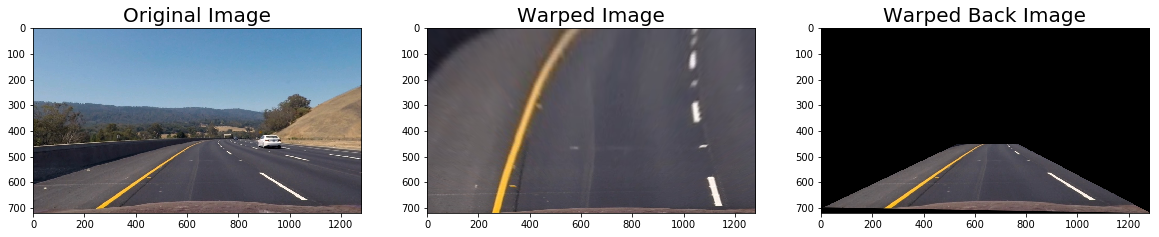

In [12]:
# load image
img = cv2.imread(images[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])

pts = np.float32([[100,700],[550,450],[750,450],[1200,720]])


M, Minv = get_transform_matrices(pts, img_size)

warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

warped_back = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=20)
ax3.imshow(warped_back)
ax3.set_title('Warped Back Image', fontsize=20)


 # Save images
# warped = cv2.resize(warped, None, fx=1 / 2, fy=1 / 2, interpolation=cv2.INTER_AREA)
# warped = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
# filename = "output/warped4.jpg"
# cv2.imwrite(filename, warped)

# warped_back = cv2.resize(warped_back, None, fx=1 / 2, fy=1 / 2, interpolation=cv2.INTER_AREA)
# warped_back = cv2.cvtColor(warped_back, cv2.COLOR_RGB2BGR)
# filename = "output/warped_back4.jpg"
# cv2.imwrite(filename, warped_back)


### Here is function to optimize the choice of source points

In [13]:
def trapezoid_vertices(image, bottom_width=0.85,top_width=0.07,height=0.40, car_hood=45):
 
    imshape = image.shape
    
    vertices = np.array([[\
        ((imshape[1] * (1 - bottom_width)) // 2, imshape[0]-car_hood),\
        ((imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height + car_hood),\
        (imshape[1] - (imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height + car_hood),\
        (imshape[1] - (imshape[1] * (1 - bottom_width)) // 2, imshape[0] - car_hood)]]\
        , dtype=np.int32)
    
    return vertices

### Optimize source points by using a straight road image. Choose source points that warp lane lines to be vertical

Text(0.5,1,'Warped Back Image')

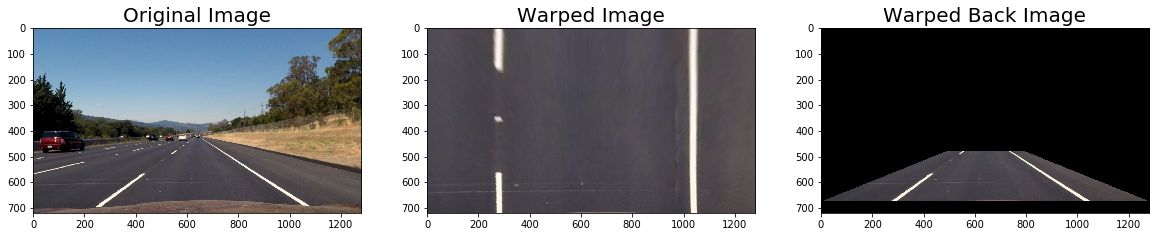

In [14]:

img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])

src = np.array([[262, 677], [580, 460], [703, 460], [1040, 677]]).astype(np.float32)
dst = np.array([[262, 720], [262, 0], [1040, 0], [1040, 720]]).astype(np.float32)


pts = trapezoid_vertices(img, bottom_width=0.4,top_width=0.092,height=0.4, car_hood=45)  # 1, 0.046, 0.4 --> 1, 0.167, 0,35

pts = pts.reshape(pts.shape[1:])
pts = pts.astype(np.float32)



M, Minv = get_transform_matrices(pts, img_size)


warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)


warped_back = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=20)
ax3.imshow(warped_back)
ax3.set_title('Warped Back Image', fontsize=20)

### Okay . We finished Transformation images

## 3. Image Thresholding, Binary Image

###  Sobel operators and color spaces to  make lane lines clearly visible by enhancing the edges of vertical lines.

In [15]:
dist_pickle = pickle.load( open( "camera_cal/camera_cal_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

dist_pickle = pickle.load( open( "camera_cal/perspective_trans_matrices.p", "rb" ) )
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

### Test the calibration Images

Text(0.5,1,'Undistorted Image')

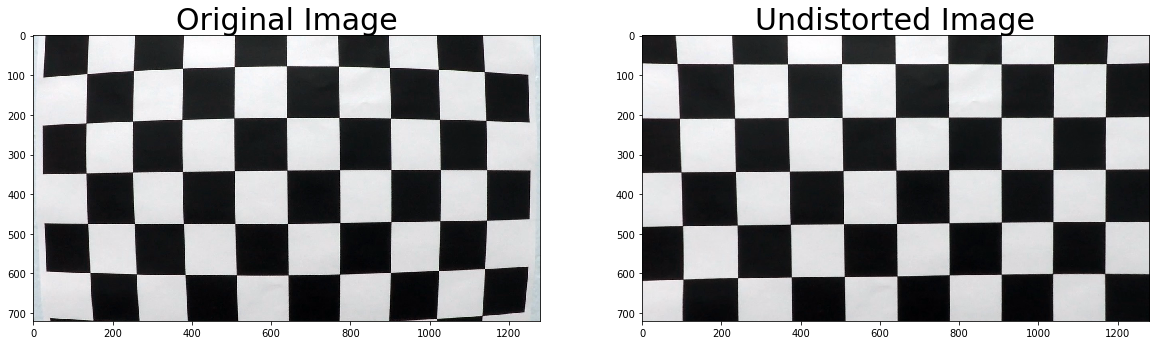

In [16]:

img = cv2.imread('camera_cal/test_image/test_image2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_image/test_undist2.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Test Perspective Transformation

Text(0.5,1,'Warped Back Image')

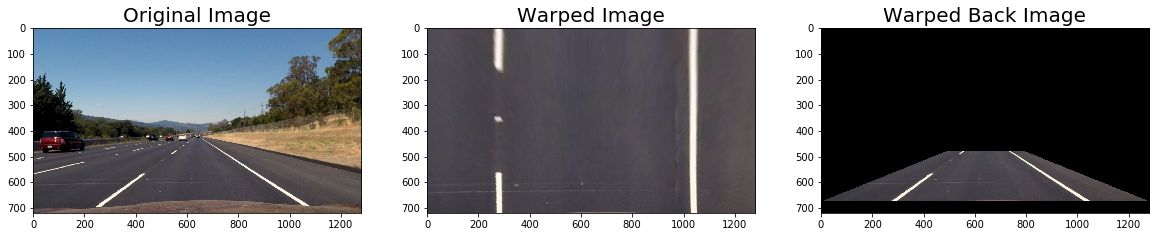

In [17]:

img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])


warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

warped_back = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=20)
ax3.imshow(warped_back)
ax3.set_title('Warped Back Image', fontsize=20)

 #### Sobel gradient in X (Sx) and gradient magnitude (square root of the squares of the individual x and y gradients) were the best approaches to make the lines clear.

### First sobel gradients

In [18]:
# Make a list of images
images = glob.glob('test_images/test*.jpg')
images.sort()

In [19]:
images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

Text(0.5,1,'Original Image')

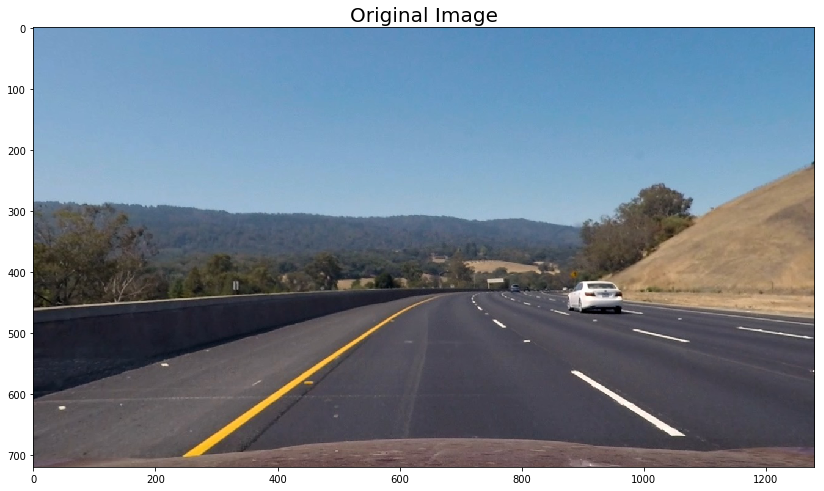

In [20]:

img = cv2.imread(images[2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])

# print('This image is:', type(img), 'with dimesions:', img.shape)

f, ax = plt.subplots(1, sharex=True, figsize=(14,1*8.7))
f.subplots_adjust(hspace=0.2, wspace=0.05)
plt.imshow(img)
ax.set_title('Original Image', fontsize=20)

### HLS color space

Text(0.5,1,'S channel')

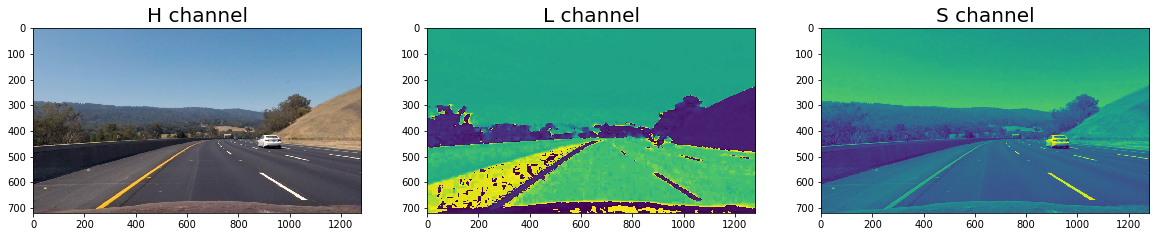

In [21]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('H channel', fontsize=20)
ax2.imshow(H)
ax2.set_title('L channel', fontsize=20)
ax3.imshow(L)
ax3.set_title('S channel', fontsize=20)



### Sobel absolute gradient X threshold.

Text(0.5,1,'Sobel Gradient X')

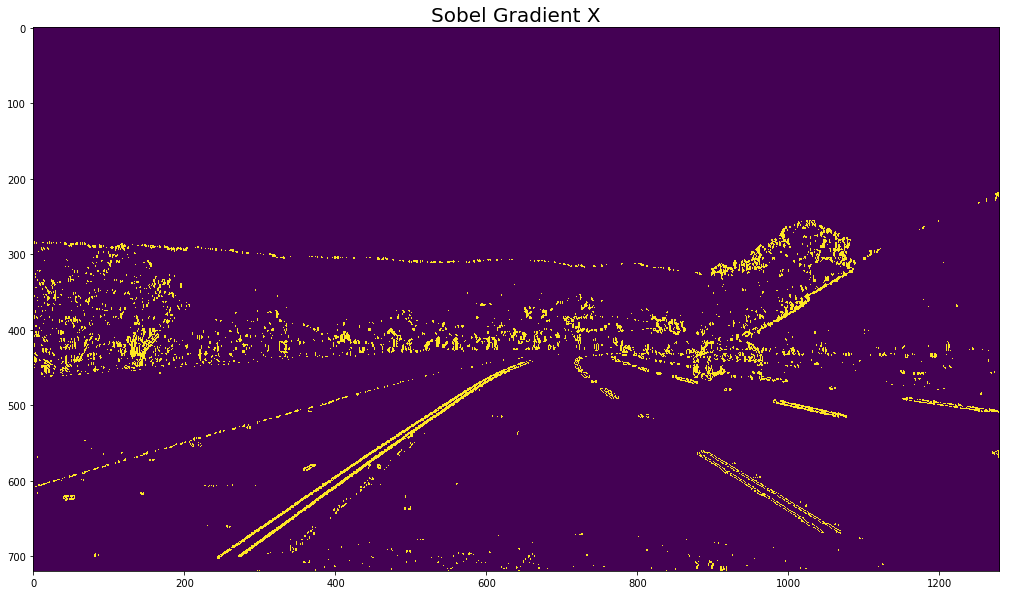

In [22]:
thresh_min=20
thresh_max=100

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))

scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
binary_output = np.zeros_like(scaled_sobel)

binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# binary_output = cv2.cvtColor(binary_output, cv2.COLOR_RGB2GRAY)

f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(binary_output)
ax1.set_title('Sobel Gradient X', fontsize=20)


# f, axarr = plt.subplots(2, sharex=True, figsize=(14,2*8.3))
# f.subplots_adjust(hspace=0.1, wspace=0.05)
# axarr[0].imshow(binary_output, cmap=None) 
# axarr[0].set_title('Sobel Gradient X', fontsize=20)
# axarr[1].imshow(binary_output, cmap='gray')  # Binary Output
# axarr[1].set_title('Sobel Gradient X', fontsize=20)

### Combine Sobel gradient and HLS color thresholds

In [23]:
def thresholding(img, s_thresh=(170, 254), sx_thresh=(15, 100)):
    img = np.copy(img)

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
  
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
   
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
   
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
  
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined = np.zeros_like(s_channel)
    combined[((s_binary == 1) | (sxbinary == 1))] = 1
    return color_binary, combined

In [24]:
color_binary, combined = thresholding(img)

Text(0.5,1,'Gray Scale')

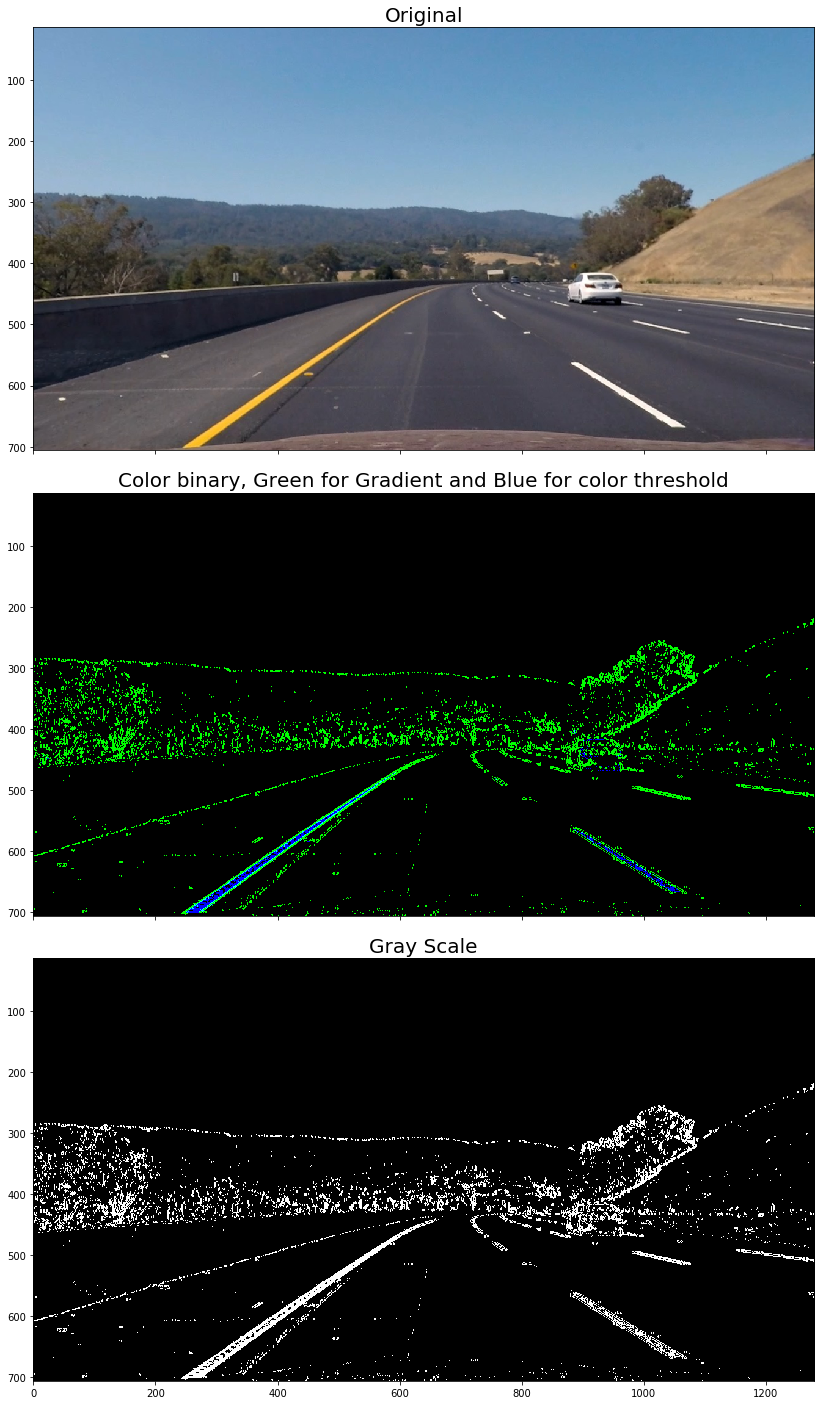

In [25]:
# Display Images
f, axarr = plt.subplots(3, sharex=True, figsize=(14,3*8.3))
f.subplots_adjust(hspace=0.1, wspace=0.05)
axarr[0].imshow(img, cmap=None)  # Orginal 
axarr[0].set_title('Original', fontsize=20)
axarr[1].imshow(color_binary, cmap=None) # Color Binary
axarr[1].set_title('Color binary, Green for Gradient and Blue for color threshold', fontsize=20)
axarr[2].imshow(combined, cmap='gray') # Combined
axarr[2].set_title('Gray Scale', fontsize=20)

### Test For Raod Images

In [26]:

def plotImages_thresholdings(images, mtx, dist, ncols=1, cmap=None, prefix_label = 'label:'):
        
    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten() # iterate on plots via 1D
    
    for idx, fname in enumerate(images):
        # load image, change color space, undistort
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.undistort(img, mtx, dist, None, mtx)       

        # Apply threshold
        color_binary, combined = thresholding(img)
        
        axarr[idx].axis('off')
        axarr[idx].imshow(combined, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)

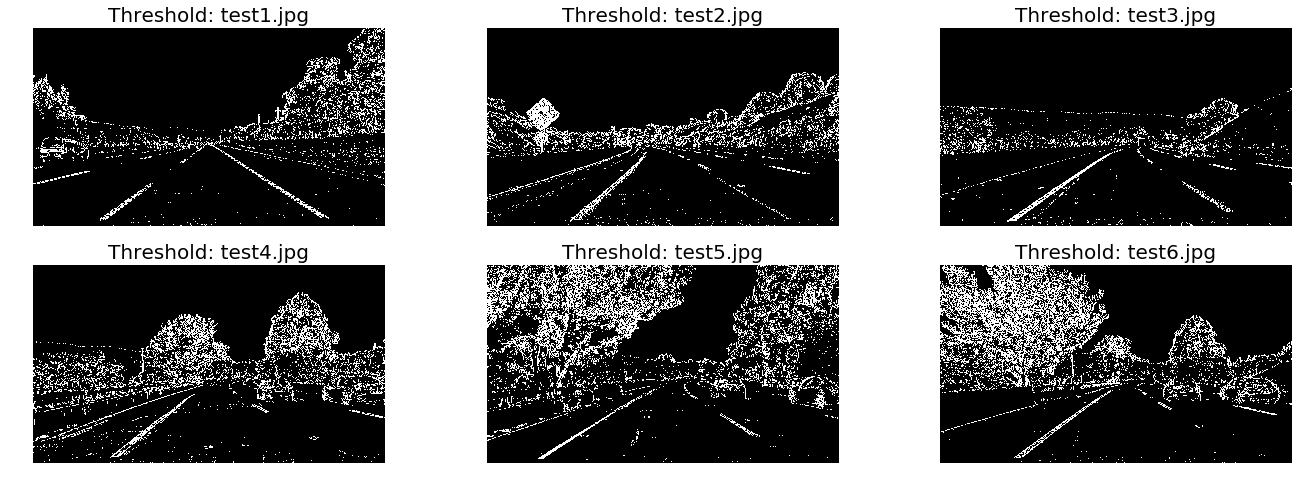

In [27]:
plotImages_thresholdings(images, mtx, dist, ncols=3, cmap='gray', prefix_label = 'Threshold:')

### Let's apply perspective transformation on a test image.

Text(0.5,1,'warped')

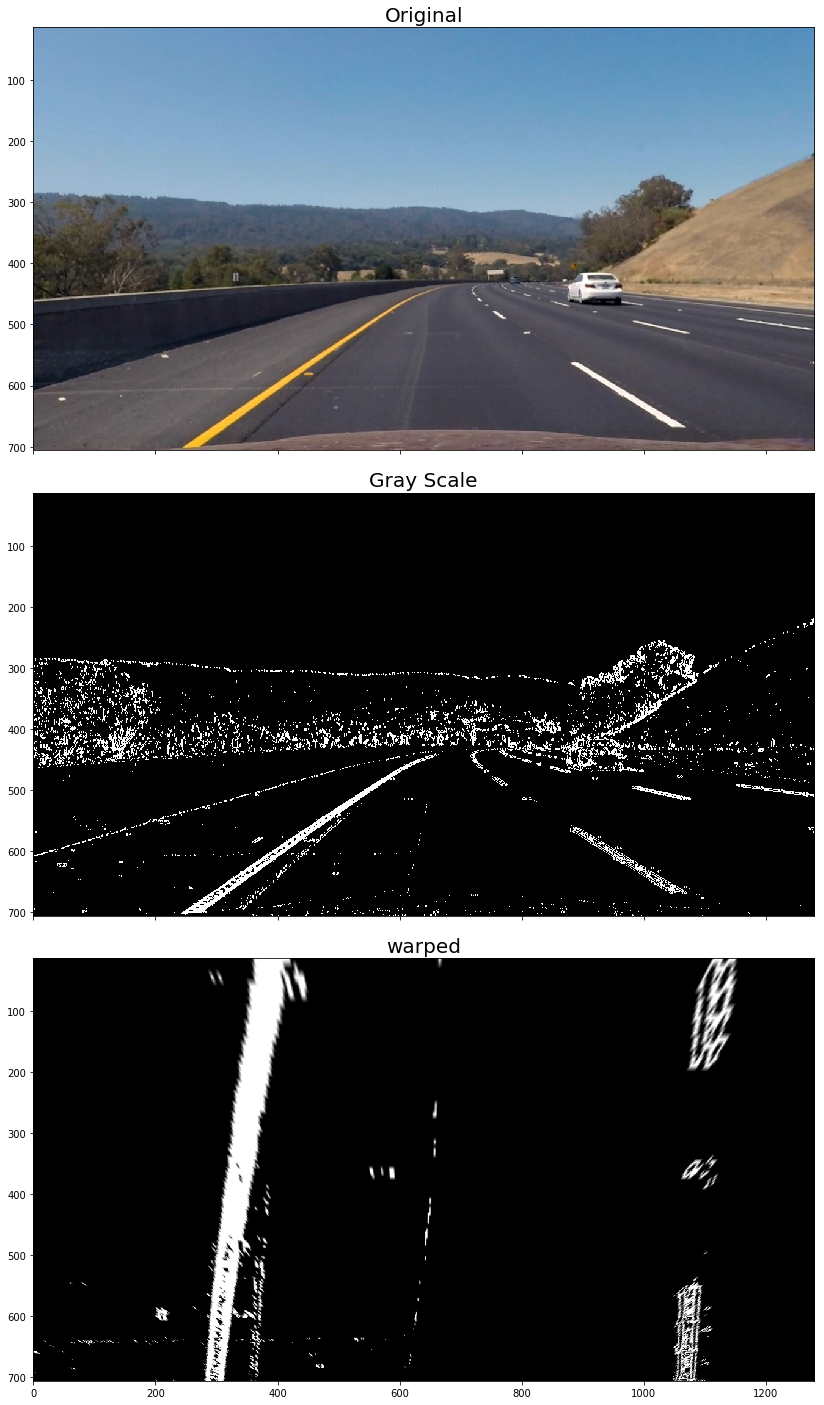

In [28]:

color_binary, combined = thresholding(img)

warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

f, axarr = plt.subplots(3, sharex=True, figsize=(14,3*8.3))
f.subplots_adjust(hspace=0.1, wspace=0.05)
axarr[0].imshow(img, cmap=None) # Orginal
axarr[0].set_title('Original', fontsize=20)
axarr[1].imshow(combined, cmap='gray') # Combined
axarr[1].set_title('Gray Scale', fontsize=20)
axarr[2].imshow(warped, cmap='gray') # Wraped
axarr[2].set_title('warped', fontsize=20)

### Now let's apply it several test images.

In [29]:

def plotImages_perspective(images, mtx, dist, M, ncols=1, cmap=None, prefix_label = 'label:'):

    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten()
    
    for idx, fname in enumerate(images):

        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.undistort(img, mtx, dist, None, mtx)       
        img_size = (img.shape[1], img.shape[0])
        
  
        color_binary, combined = thresholding(img)


        warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
        
        axarr[idx].axis('off')
        axarr[idx].imshow(warped, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)


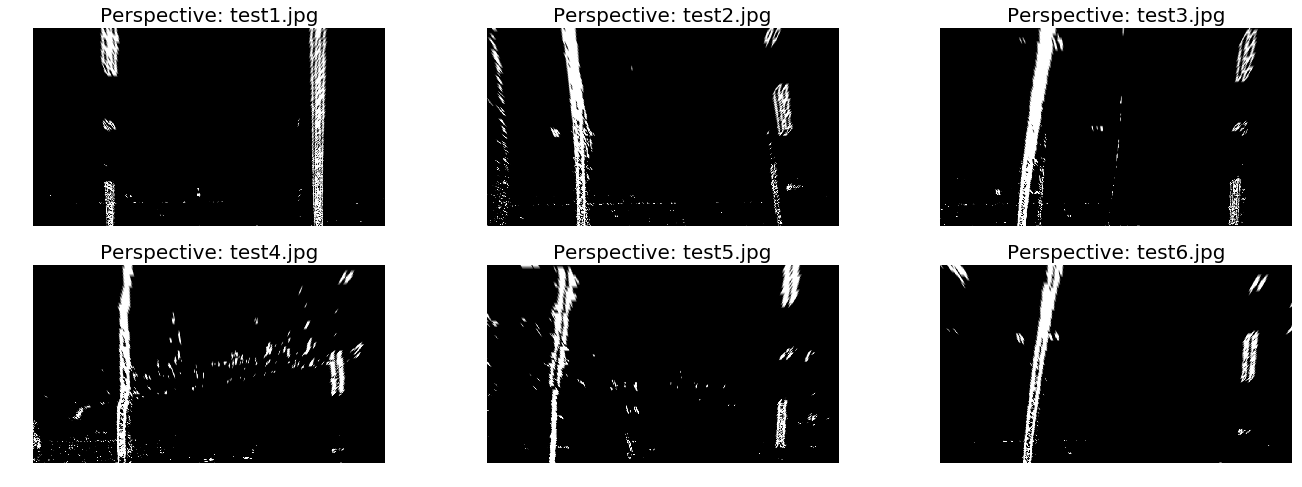

In [30]:
plotImages_perspective(images, mtx, dist, M, ncols=3, cmap='gray', prefix_label = 'Perspective:')

### Simple Detection using Filtering

In [31]:
def grayscale(img):

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


In [32]:
def filter_WhiteYellow(image):

    threshold = 200 
    high_threshold = np.array([255, 255, 255])
    low_threshold = np.array([threshold, threshold, threshold])
    mask = cv2.inRange(image, low_threshold, high_threshold)
    white_img = cv2.bitwise_and(image, image, mask=mask)

    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    high_threshold = np.array([110,255,255])
    low_threshold = np.array([90,100,100])  
    mask = cv2.inRange(hsv_img, low_threshold, high_threshold)
    yellow_img = cv2.bitwise_and(image, image, mask=mask)


    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    return filtered_img

Text(0.5,1,'Yellow & White Filter Converted to Gray Scale')

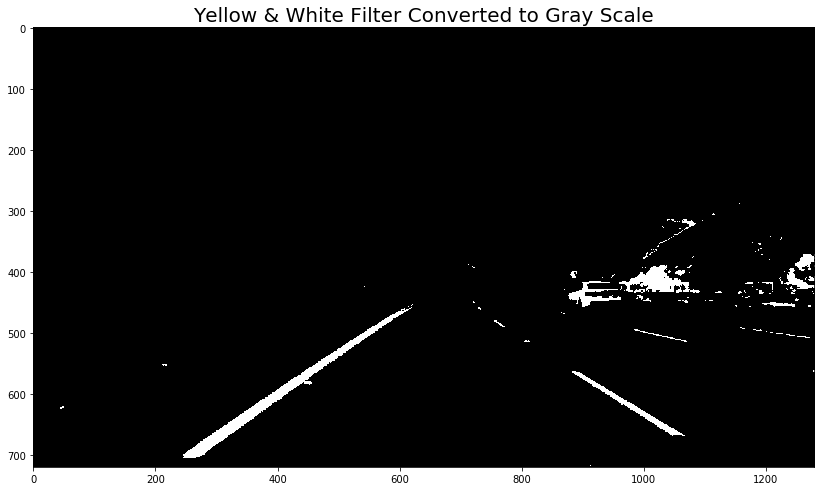

In [33]:

filtered_img = filter_WhiteYellow(img)

gray = grayscale(filtered_img)
binary_output2 = np.zeros_like(gray)
binary_output2[(gray > 0)] = 1


f, ax = plt.subplots(1, sharex=True, figsize=(14,1*8.3))
f.subplots_adjust(hspace=0.1, wspace=0.05)
plt.imshow(binary_output2, cmap='gray') 
ax.set_title('Yellow & White Filter Converted to Gray Scale', fontsize=20)

### Let's see how it looks like on transformed images

In [34]:
def plotImages_perspective2(images, mtx, dist, M, ncols=1, cmap=None, prefix_label = 'label:'):
    
    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten() # iterate on plots via 1D
    
    for idx, fname in enumerate(images):
       
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.undistort(img, mtx, dist, None, mtx)       
        img_size = (img.shape[1], img.shape[0])
        
       
        filtered_img = filter_WhiteYellow(img)
        gray = grayscale(filtered_img)
        binary_output2 = np.zeros_like(gray)
        binary_output2[(gray > 0)] = 1

        warped = cv2.warpPerspective(binary_output2, M, img_size, flags=cv2.INTER_LINEAR)
        
        axarr[idx].axis('off')
        axarr[idx].imshow(warped, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)

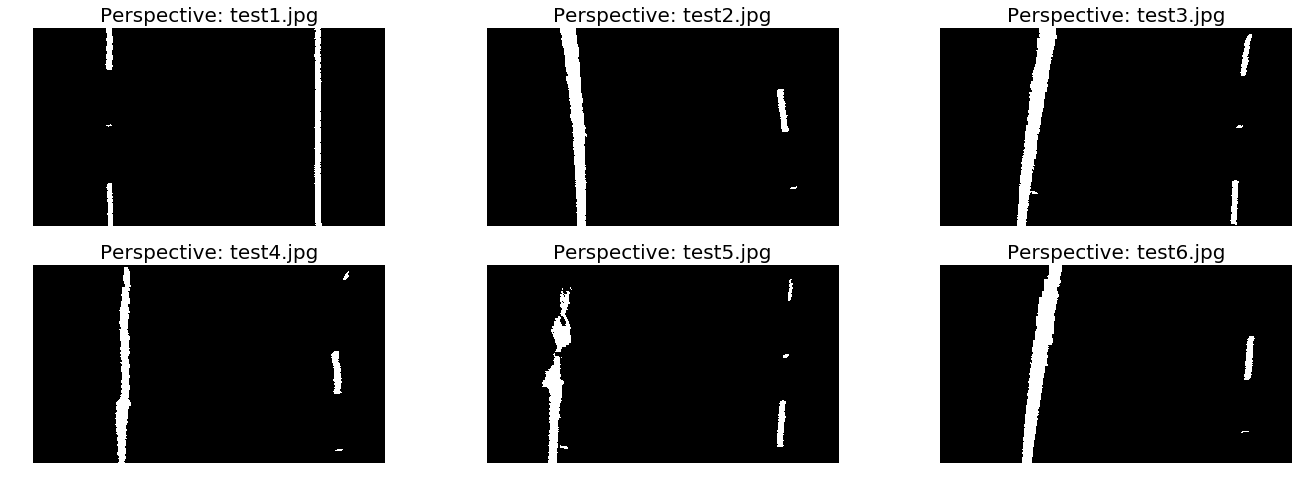

In [35]:
plotImages_perspective2(images, mtx, dist, M, ncols=3, cmap='gray', prefix_label = 'Perspective:')

### Combine Sobel gradient and Yellow/White filter

Text(0.5,1,'Combined')

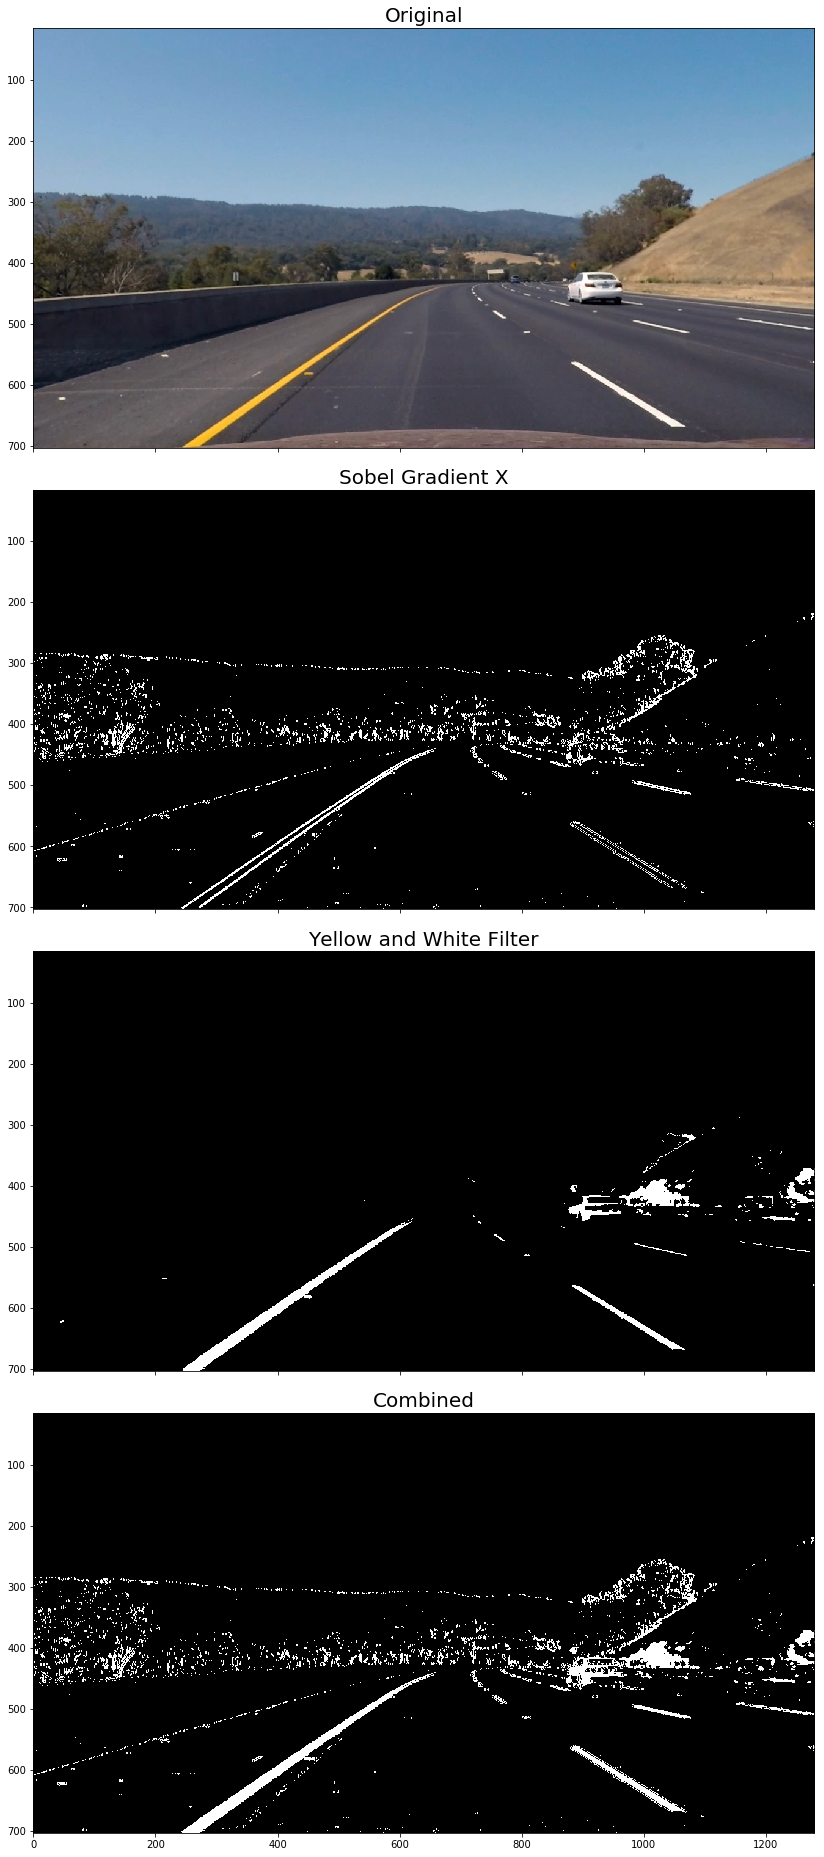

In [36]:
thresh_min=20
thresh_max=100

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))

scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

binary_output = np.zeros_like(scaled_sobel)

binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1


filtered_img = filter_WhiteYellow(img)

gray = grayscale(filtered_img)
binary_output2 = np.zeros_like(gray)
binary_output2[(gray > 0)] = 1

combined = np.zeros_like(binary_output)
combined[((binary_output2 == 1) | (binary_output == 1))] = 1

# Display Images
f, axarr = plt.subplots(4, sharex=True, figsize=(14,4*8.3))
f.subplots_adjust(hspace=0.1, wspace=0.05)
axarr[0].imshow(img, cmap=None) 
axarr[0].set_title('Original', fontsize=20)
axarr[1].imshow(binary_output, cmap='gray') 
axarr[1].set_title('Sobel Gradient X', fontsize=20)
axarr[2].imshow(binary_output2, cmap='gray') 
axarr[2].set_title('Yellow and White Filter', fontsize=20)
axarr[3].imshow(combined, cmap='gray') 
axarr[3].set_title('Combined', fontsize=20)

### Plot perspectives on several test images

In [37]:

def plotImages_perspective3(images, mtx, dist, M, ncols=1, cmap=None, prefix_label = 'label:'):
    
    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten()
    
    for idx, fname in enumerate(images):
        
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.undistort(img, mtx, dist, None, mtx)       
        img_size = (img.shape[1], img.shape[0])
        

        thresh_min=20
        thresh_max=100
     
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
       
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
        binary_output = np.zeros_like(scaled_sobel)
        
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        

        filtered_img = filter_WhiteYellow(img)
        gray = grayscale(filtered_img)
        binary_output2 = np.zeros_like(gray)
        binary_output2[(gray > 0)] = 1
        
       
        combined = np.zeros_like(binary_output)
        combined[((binary_output2 == 1) | (binary_output == 1))] = 1


        warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
        
        axarr[idx].axis('off')
        axarr[idx].imshow(warped, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)


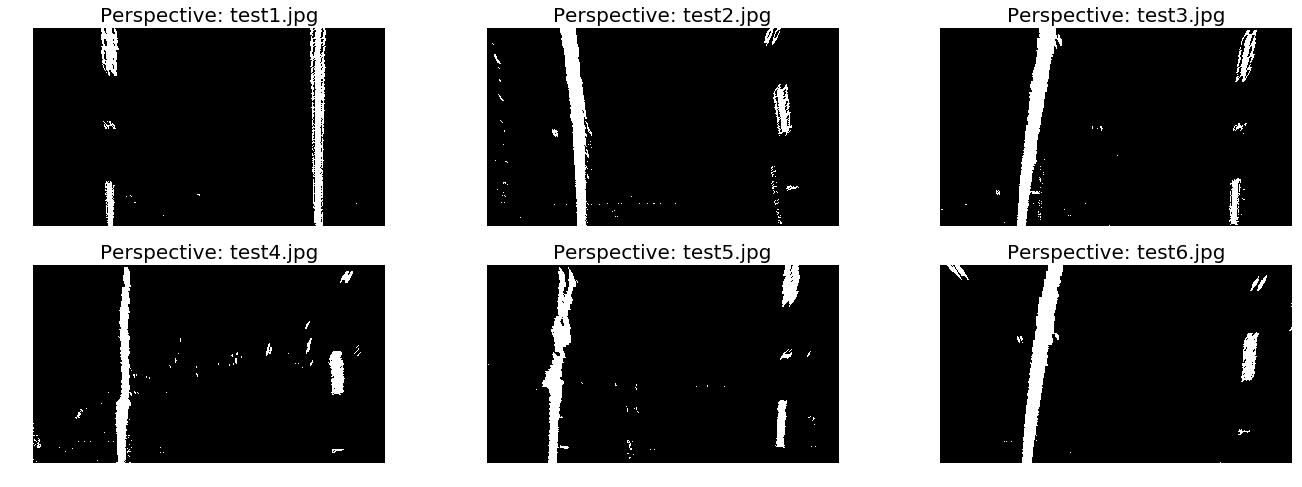

In [38]:
plotImages_perspective3(images, mtx, dist, M, ncols=3, cmap='gray', prefix_label = 'Perspective:')

### Pipeline using combined gradient and color threshold

In [39]:
def pipeline_thresholding2(img, M, img_size, sx_thresh=(15, 100)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
 
    binary_output = np.zeros_like(scaled_sobel)
  
    binary_output[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1


    filtered_img = filter_WhiteYellow(img)

    gray = grayscale(filtered_img)
    binary_output2 = np.zeros_like(gray)
    binary_output2[(gray > 0)] = 1

    combined = np.zeros_like(binary_output)
    combined[((binary_output2 == 1) | (binary_output == 1))] = 1
    
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, combined

In [40]:
warped, combined = pipeline_thresholding2(img, M, img_size)

Text(0.5,1,'Warped')

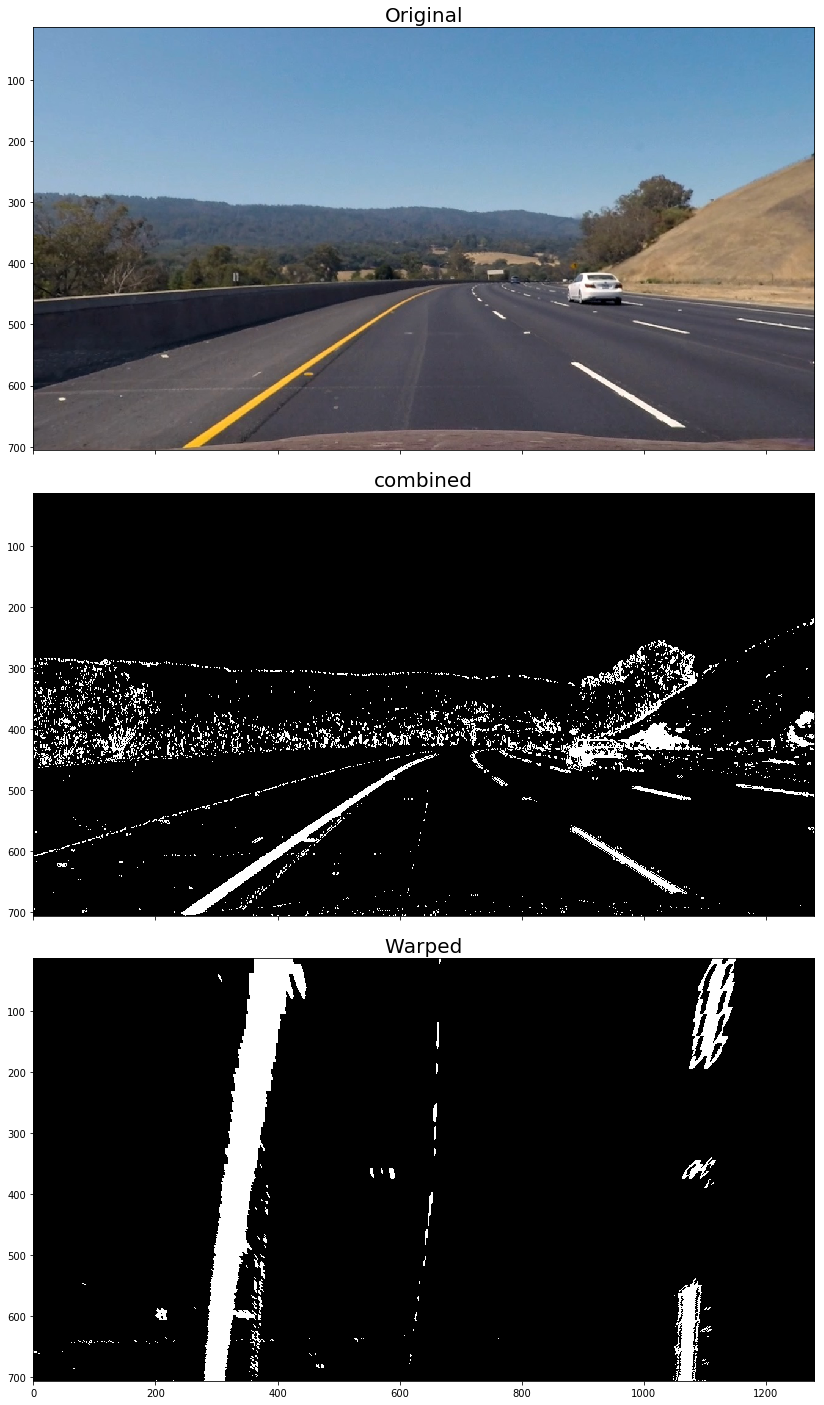

In [41]:
# Display Images
f, axarr = plt.subplots(3, sharex=True, figsize=(14,3*8.3))
f.subplots_adjust(hspace=0.1, wspace=0.05)
axarr[0].imshow(img, cmap=None) 
axarr[0].set_title('Original', fontsize=20)
axarr[1].imshow(combined, cmap='gray') 
axarr[1].set_title('combined', fontsize=20)
axarr[2].imshow(warped, cmap='gray') 
axarr[2].set_title('Warped', fontsize=20)

### Pipeline using only Yellow & White filter

In [42]:
def pipeline_thresholding3(img, M, img_size):

    filtered_img = filter_WhiteYellow(img)

    gray = grayscale(filtered_img)
    binary_output2 = np.zeros_like(gray)
    binary_output2[(gray > 0)] = 1
    
    warped = cv2.warpPerspective(binary_output2, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, binary_output2


In [43]:
warped, binary_output2 = pipeline_thresholding3(img, M, img_size)

Text(0.5,1,'Warped')

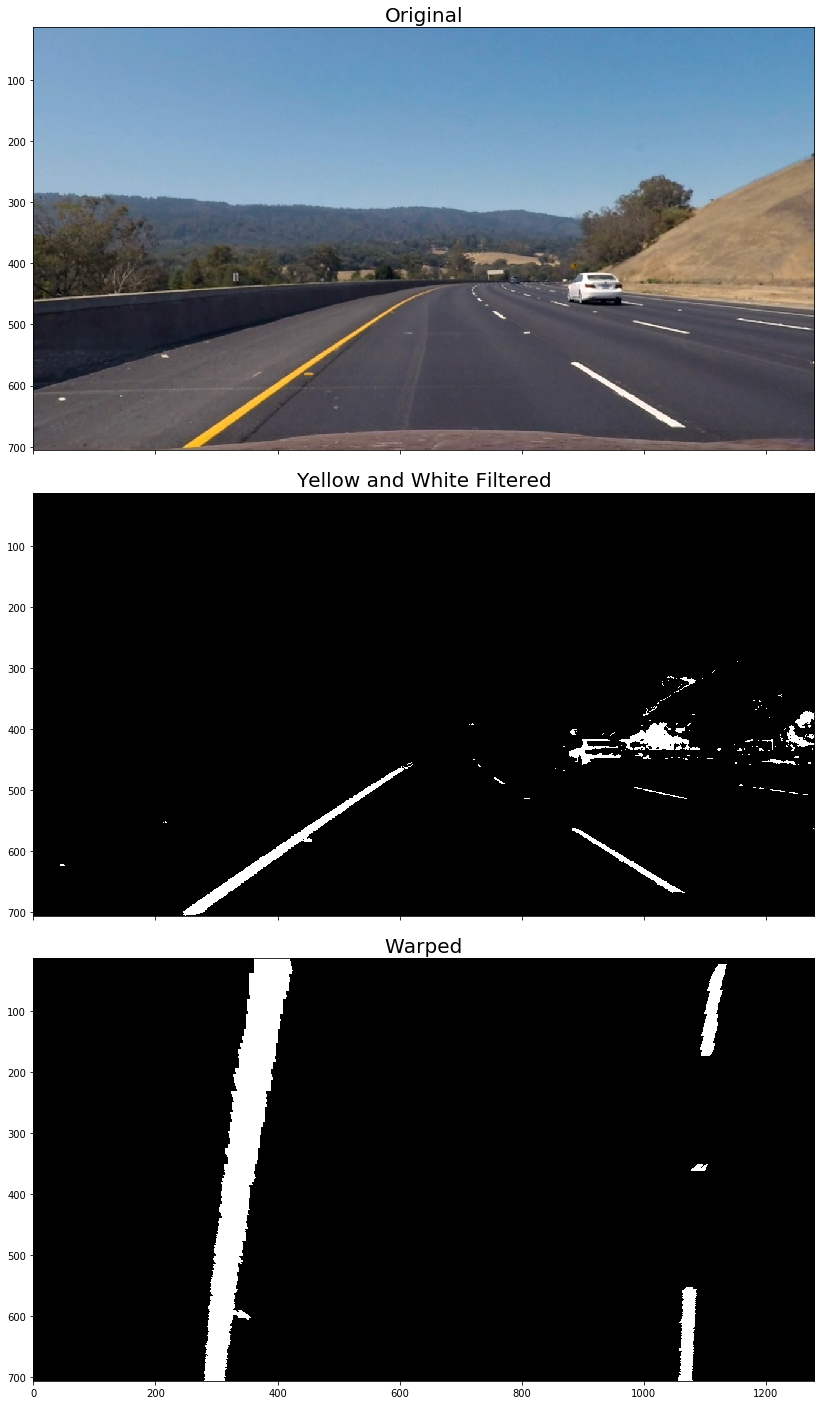

In [44]:
# Display Images
f, axarr = plt.subplots(3, sharex=True, figsize=(14,3*8.3))
f.subplots_adjust(hspace=0.1, wspace=0.05)
axarr[0].imshow(img, cmap=None) 
axarr[0].set_title('Original', fontsize=20)
axarr[1].imshow(binary_output2, cmap='gray') 
axarr[1].set_title('Yellow and White Filtered', fontsize=20)
axarr[2].imshow(warped, cmap='gray') 
axarr[2].set_title('Warped', fontsize=20)

## 4. Lane Detection

### Implement Sliding Windows and Fit a Polynomial

Text(0.5,1,'First initial image')

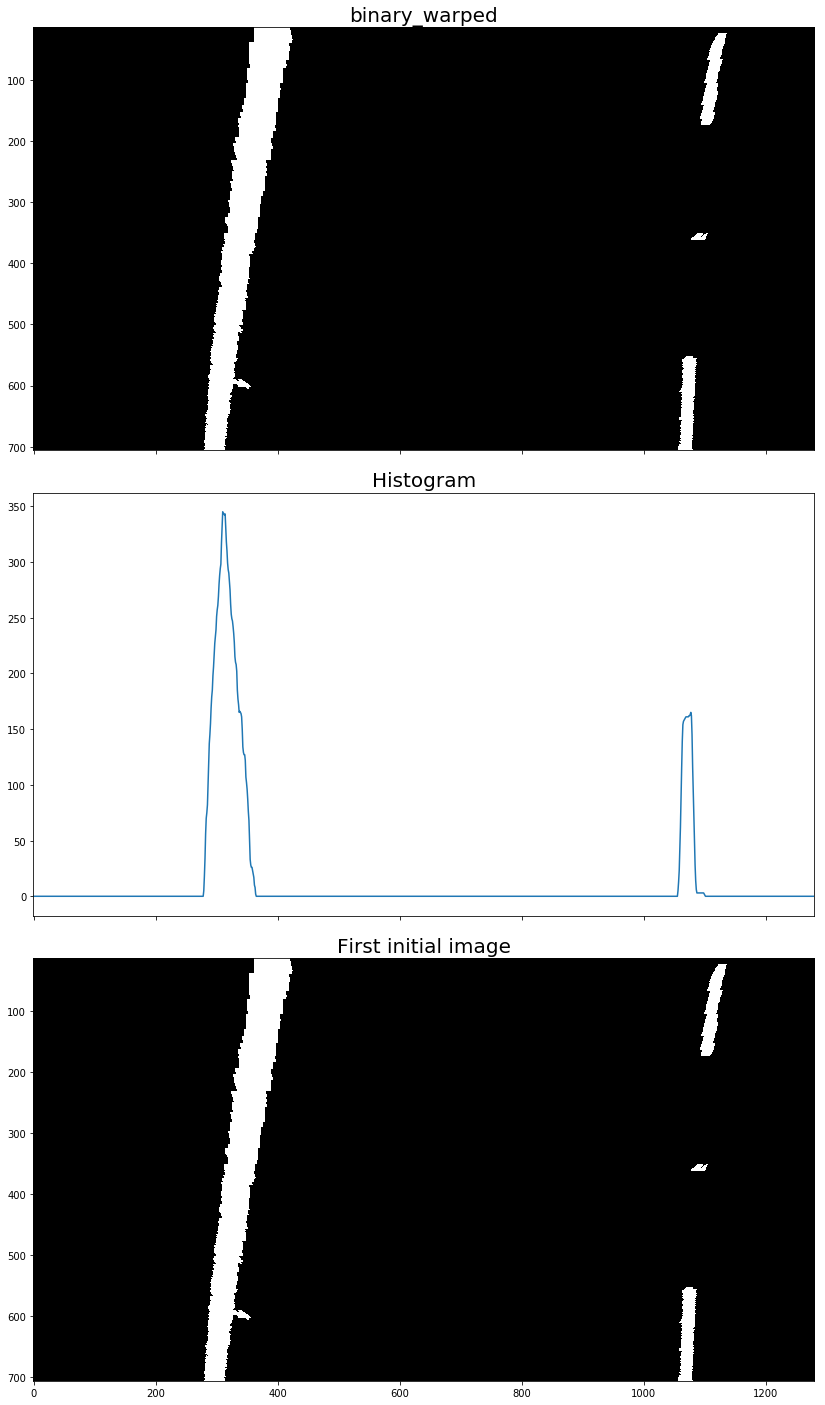

In [45]:
binary_warped, binary_threshold = pipeline_thresholding3(img, M, img_size)


histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255


# Visualize it
f, axarr = plt.subplots(3, sharex=True, figsize=(14,3*8.3))
f.subplots_adjust(hspace=0.1, wspace=0.05)
axarr[0].imshow(binary_warped, cmap='gray') 
axarr[0].set_title('binary_warped', fontsize=20)
axarr[1].plot(histogram) 
axarr[1].set_title('Histogram', fontsize=20)
axarr[2].imshow(out_img, cmap='gray') 
axarr[2].set_title('First initial image', fontsize=20)

In [46]:

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9

window_height = np.int(binary_warped.shape[0]/nwindows)

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base
rightx_current = rightx_base

margin = 100

minpix = 50

left_lane_inds = []
right_lane_inds = []


for window in range(nwindows):
  
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
   
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
  
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 


left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Visualization

(720, 0)

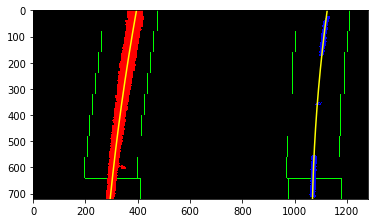

In [47]:

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Skip the sliding windows step once you know where the lines are

In [48]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  


leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

### Visualization

(720, 0)

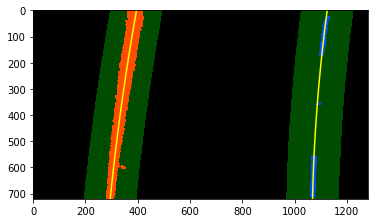

In [49]:

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Find Radius of Carvature

### Now we have polynomial fits and we can calculate the radius of curvature as follows:

In [50]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

9433.45615492 6508.64588994


### So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:

In [51]:

ym_per_pix = 30/720 
xm_per_pix = 3.7/700 


left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print(left_curverad, 'm\t', right_curverad, 'm')


3052.62980365 m	 2136.18865468 m


## Final Drawing on Lane

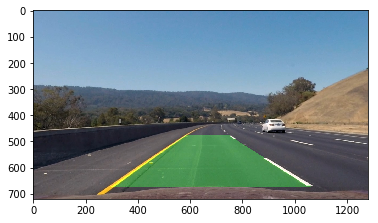

In [52]:

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)

## 5. Pipeline , Images and Video

In [53]:
def filter_WhiteYellow(image):

    threshold = 200 
    high_threshold = np.array([255, 255, 255]) 
    low_threshold = np.array([threshold, threshold, threshold]) 
    mask = cv2.inRange(image, low_threshold, high_threshold)
    white_img = cv2.bitwise_and(image, image, mask=mask)

  
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    high_threshold = np.array([110,255,255]) 
    low_threshold = np.array([90,100,100])  
    mask = cv2.inRange(hsv_img, low_threshold, high_threshold)
    yellow_img = cv2.bitwise_and(image, image, mask=mask)

   
    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    return filtered_img

def thresholding(image, M):
  
    img_size = (image.shape[1], image.shape[0])
  
    filtered_img = filter_WhiteYellow(image)
    
    gray = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
  
    binary_threshold = np.zeros_like(gray)
    binary_threshold[(gray > 0)] = 1
 
    warped = cv2.warpPerspective(binary_threshold, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

In [54]:
class Line():

    def __init__(self):

        self.detected = False

 
        self.recent_xfitted = []

    
        self.bestx = None

  
        self.best_fit = None


        self.current_fit = [np.array([False])]


        self.radius_of_curvature = None

     
        self.line_base_pos = None


        self.diffs = np.array([0,0,0], dtype='float')


        self.all_x = None


        self.all_y = None

In [55]:
def sliding_window(binary_warped, line):
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)


    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    nwindows = 9


    window_height = np.int(binary_warped.shape[0]/nwindows)

  
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100

    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
 
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), color=(0,255,0), thickness=2) # Green
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), color=(0,255,0), thickness=2) # Green
  
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if line == 'left':
        return leftx, lefty
    elif line == 'right':
        return rightx, righty

    


In [56]:
def non_sliding(binary_warped, line):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    left_fit = left_line.current_fit
    right_fit = right_line.current_fit

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
        & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
        & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if line == 'left':
        return leftx, lefty
    elif line == 'right':
        return rightx, righty

In [57]:
def pipeline(start_img):
    '''
    Incoming image must be RGB!!
    '''
    start_img = cv2.undistort(start_img, mtx, dist, None, mtx)
    binary_warped = thresholding(start_img, M)

    # Check if line was detected in previous frame:
    if left_line.detected == True:
        leftx, lefty = non_sliding(binary_warped, 'left')
    elif left_line.detected == False:
        leftx, lefty = sliding_window(binary_warped, 'left')
        left_line.detected = True
    if right_line.detected == True:
        rightx, righty = non_sliding(binary_warped, 'right')
    elif right_line.detected == False:
        rightx, righty = sliding_window(binary_warped, 'right')
        right_line.detected = True

   
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    left_line.current_fit = left_fit
    right_line.current_fit = right_fit


    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

  
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 


    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)

    y_eval = np.max(ploty) 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    midpoint = np.int(start_img.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    offset = (midpoint - middle_of_lane) * xm_per_pix

  
    warped_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warped = np.dstack((warped_zero, warped_zero, warped_zero))

    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warped, np.int_([pts]), (0,255, 0))

  
    img_size = (start_img.shape[1], start_img.shape[0])
    unwarped = cv2.warpPerspective(color_warped, Minv, img_size, flags=cv2.INTER_LINEAR)

  
    result = cv2.addWeighted(start_img, 1, unwarped, 0.3, 0)
    radius = np.mean([left_curverad, right_curverad])

    # Add radius and offset calculations to top of video
    cv2.putText(result,"L. Lane Radius: " + "{:0.2f}".format(left_curverad/1000) + 'km', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"R. Lane Radius: " + "{:0.2f}".format(right_curverad/1000) + 'km', org=(50,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position: " + "{:0.2f}".format(offset) + 'm', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)

    return result

In [58]:
# Make a list of images
images = glob.glob('test_images/test*.jpg')
images.sort()

In [59]:
images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

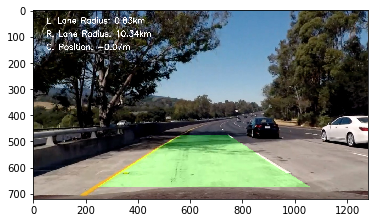

In [60]:
left_line = Line()
right_line = Line()

img = cv2.imread(images[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = pipeline(img)

plt.imshow(result)

### Plot Several Images

In [61]:
#  Plotting function for images
def plotImages(images, ncols=1, cmap=None, prefix_label = 'label:'):
#     from os.path import basename
    
    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten()
    
    for idx, fname in enumerate(images):
        
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
   
        left_line = Line()
        right_line = Line()
        result = pipeline(img)
        
        axarr[idx].axis('off')
        axarr[idx].imshow(result, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)

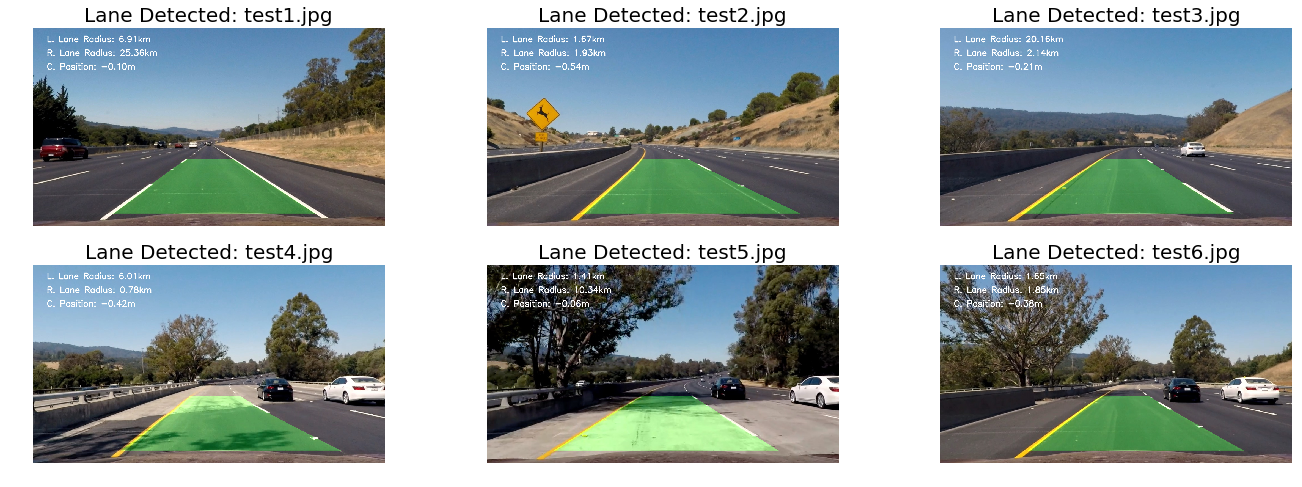

In [62]:
plotImages(images, ncols=3, cmap='gray', prefix_label = 'Lane Detected:')

### Test on Videos

In [63]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [64]:
white_output = 'test_videos_output/annotated_project_video.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(pipeline) #N.Bthis function expects color images
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/annotated_project_video.mp4
[MoviePy] Writing video test_videos_output/annotated_project_video.mp4


100%|█████████▉| 1260/1261 [05:52<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/annotated_project_video.mp4 

CPU times: user 7min 43s, sys: 1min 15s, total: 8min 59s
Wall time: 5min 59s


In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# The End of Road Surface and Lane Detection Project